# This notebook seeks to Answer
* How do classifier (e.g.: linear probe) transfer between different types of attacks?

In [1]:
from pathlib import Path
import os
# Get the current working directory (where the notebook is)
notebook_dir = Path.cwd()

# Move up to the root directory (parent of 'notebooks')
project_root = notebook_dir.parent.parent
os.chdir(project_root)


In [2]:
import pandas as pd
import sys
import os
import numpy as np
from pathlib import Path

In [3]:
from analysis.unsupervised import *
from analysis.supervised import *

In [ ]:
## Load rated dataset 
wild_jailbreak_path = project_root/ "datasets/latest/wildJailBreak_rated.pkl"

wei_gemma7bit = project_root / "datasets/latest/gemma-7b-it_wei_three_new_rated_merged.pkl"

wei_llama8bit = project_root / "datasets/_meta-llamaLlama-3.1-8B-Instruct_prompt_res_activations_2911202410:07:48_rated.pkl"


path = [wild_jailbreak_path, wei_gemma7bit, wei_llama8bit][2]

df = pd.read_pickle(path)

path = str(path)

In [87]:
## CONFIG
models = {
    "gemma-7b-it": {
        "num_layers": 28,
        "rating_column": "rating",
    },
    "Llama-3.1-8B-Instruct": {
        "num_layers": 32,
        "rating_column": "rating_output_text",
    },
    "Llama-3.2-3b-Instruct": {
        "num_layers": 28,
        "rating_column": "rating_output_text",       
    }
}

# Determine the model name based on the file path
def get_model_name(path):
    for model_name in models.keys():
        if model_name in str(path):
            return model_name, models[model_name]["num_layers"], models[model_name]["rating_column"]
    return "unknown"  # Default if no match is found

model_name, num_layers, rating_column = get_model_name(path)

layer= num_layers - 4
activation_column="prompt_res_activations"
num_samples = len(df)
dataset_name = "wildJailBreak" if "wildJailBreak" in str(path) else "wei_dataset"

In [88]:
# # PERCENTILE CUTOFF
# rating_column = ["rating", "rating_output_text"][1]
# # Calculate ASR for each jailbreak_prompt_name
# asr_values = []

# for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
#     # Calculate normalized value counts for each prompt
#     ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
#     if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
#         asr_values.append(ASR["Yes"])

# # Calculate the 90th percentile cutoff
# percentile = 50
# percentile_cutoff = np.percentile(asr_values, percentile)
# print(f"{percentile}th Percentile Cutoff for ASR: {percentile_cutoff}")

# # Collect successful jailbreak_prompt_names above the 90th percentile
# successful_jailbreaks = []

# for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
#     ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
#     # Check conditions: ASR["Yes"] exists and exceeds the 90th percentile
#     if "Yes" in ASR and ASR["Yes"] > percentile_cutoff:
#         successful_jailbreaks.append(jailbreak_prompt)

# # Filter the dataframe to keep only rows matching the criteria or the 'original_prompt'
# df = df[(df['jailbreak_prompt_name'].isin(successful_jailbreaks)) | (df['jailbreak_prompt_name'] == 'original_prompt')]

# # Display the count of remaining jailbreak_prompt_name values
# print(df["jailbreak_prompt_name"].value_counts())


In [89]:
## TOP 10 JAILBREAK PROMPTS
import numpy as np

# Calculate ASR (Accuracy Success Rate) for each jailbreak_prompt_name
asr_values = []

# Calculate the ASR for each jailbreak prompt
for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
    # Calculate normalized value counts for each prompt
    ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
    if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
        asr_values.append((jailbreak_prompt, ASR["Yes"]))

# Sort the ASR values in descending order and select the top 10
top_10_jailbreaks = sorted(asr_values, key=lambda x: x[1], reverse=True)[:10]

# Extract the top 10 jailbreak prompt names
top_10_jailbreak_prompt_names = [item[0] for item in top_10_jailbreaks]

# Filter the dataframe to keep only rows matching the top 10 jailbreak prompts or the 'original_prompt'
df = df[(df['jailbreak_prompt_name'].isin(top_10_jailbreak_prompt_names)) | (df['jailbreak_prompt_name'] == 'original_prompt')]

# Display the count of remaining jailbreak_prompt_name values
print(df["jailbreak_prompt_name"].value_counts())



jailbreak_prompt_name
original_prompt           600
leetspeak                 300
gcg                       300
autodan                   300
AIM                       300
prefix_injection_hello    300
style_injection_json      300
evil_confidant            300
prefix_injection          300
wikipedia_with_title      300
multi_shot_5              300
Name: count, dtype: int64


## Linear Probe

In [90]:
def extract_layer(row, layer):
    return row['prompt_res_activations'][layer][0].cpu().numpy().flatten()

In [91]:
# Add column that has 0 if "rating" is "No" and 1 if "rating" is "Yes"
df['rating_binary'] = df[rating_column].apply(lambda x: 0 if x == "No" else 1)

# Create new columns for each layer
df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)


In [92]:
results_df = probe_transfer(df, "logistic_regression", layer = layer)

results_df

rating_binary
0    26
1    26
Name: count, dtype: int64
rating_binary
1    48
0    48
Name: count, dtype: int64
rating_binary
0    31
1    31
Name: count, dtype: int64
rating_binary
0    69
1    69
Name: count, dtype: int64
rating_binary
1    101
0    101
Name: count, dtype: int64
rating_binary
1    30
0    30
Name: count, dtype: int64
rating_binary
1    51
0    51
Name: count, dtype: int64
rating_binary
0    76
1    76
Name: count, dtype: int64
rating_binary
0    53
1    53
Name: count, dtype: int64
rating_binary
1    58
0    58
Name: count, dtype: int64
rating_binary
0    51
1    51
Name: count, dtype: int64


,original_prompt,leetspeak,gcg,autodan,AIM,prefix_injection_hello,style_injection_json,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
original_prompt,1.0,0.6,0.461538,0.357143,0.560976,0.5,0.380952,0.483871,0.5,0.625,0.52381
leetspeak,0.363636,0.6,0.384615,0.571429,0.536585,0.583333,0.380952,0.612903,0.318182,0.625,0.52381
gcg,0.818182,0.5,0.307692,0.535714,0.634146,0.333333,0.428571,0.483871,0.454545,0.666667,0.571429
autodan,0.545455,0.35,0.615385,0.714286,0.463415,0.5,0.52381,0.677419,0.545455,0.458333,0.666667
AIM,0.636364,0.45,0.461538,0.535714,0.682927,0.583333,0.52381,0.709677,0.818182,0.625,0.47619
prefix_injection_hello,0.636364,0.45,0.692308,0.535714,0.487805,1.0,0.571429,0.483871,0.5,0.708333,0.47619
style_injection_json,0.363636,0.5,0.384615,0.464286,0.463415,0.833333,0.904762,0.516129,0.454545,0.75,0.571429
evil_confidant,0.818182,0.5,0.384615,0.678571,0.512195,0.5,0.52381,0.645161,0.727273,0.666667,0.571429
prefix_injection,0.818182,0.45,0.384615,0.535714,0.609756,0.916667,0.619048,0.741935,0.863636,0.708333,0.52381
wikipedia_with_title,0.545455,0.5,0.538462,0.642857,0.512195,0.666667,0.47619,0.645161,0.545455,0.916667,0.619048


In [93]:
results_df.describe()

,original_prompt,leetspeak,gcg,autodan,AIM,prefix_injection_hello,style_injection_json,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
count,11.000000,11.0,11.000000,11.000000,11.000000,11.0,11.00000,11.000000,11.0,11.000,11.00000
unique,5.000000,4.0,6.000000,8.000000,9.000000,8.0,8.00000,7.000000,8.0,7.000,6.00000
top,0.363636,0.5,0.384615,0.535714,0.463415,0.5,0.52381,0.483871,0.5,0.625,0.52381
freq,3.000000,5.0,4.000000,4.000000,2.000000,3.0,3.00000,3.000000,2.0,3.000,3.00000


In [94]:
results_df.mean()

original_prompt           0.628099
leetspeak                 0.490909
gcg                       0.447552
autodan                   0.561688
AIM                       0.549889
prefix_injection_hello    0.651515
style_injection_json      0.549784
evil_confidant            0.592375
prefix_injection           0.57438
wikipedia_with_title      0.647727
multi_shot_5              0.580087
dtype: object

In [95]:
results_df.mean(axis=1)


original_prompt           0.544845
leetspeak                 0.500041
gcg                       0.521286
autodan                   0.550929
AIM                       0.591158
prefix_injection_hello    0.594729
style_injection_json      0.564195
evil_confidant            0.593446
prefix_injection          0.651972
wikipedia_with_title      0.600741
multi_shot_5              0.560664
dtype: object

In [96]:
results_df.mean(axis=0)

original_prompt           0.628099
leetspeak                 0.490909
gcg                       0.447552
autodan                   0.561688
AIM                       0.549889
prefix_injection_hello    0.651515
style_injection_json      0.549784
evil_confidant            0.592375
prefix_injection           0.57438
wikipedia_with_title      0.647727
multi_shot_5              0.580087
dtype: object

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:535: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df = results_df.fillna(0)


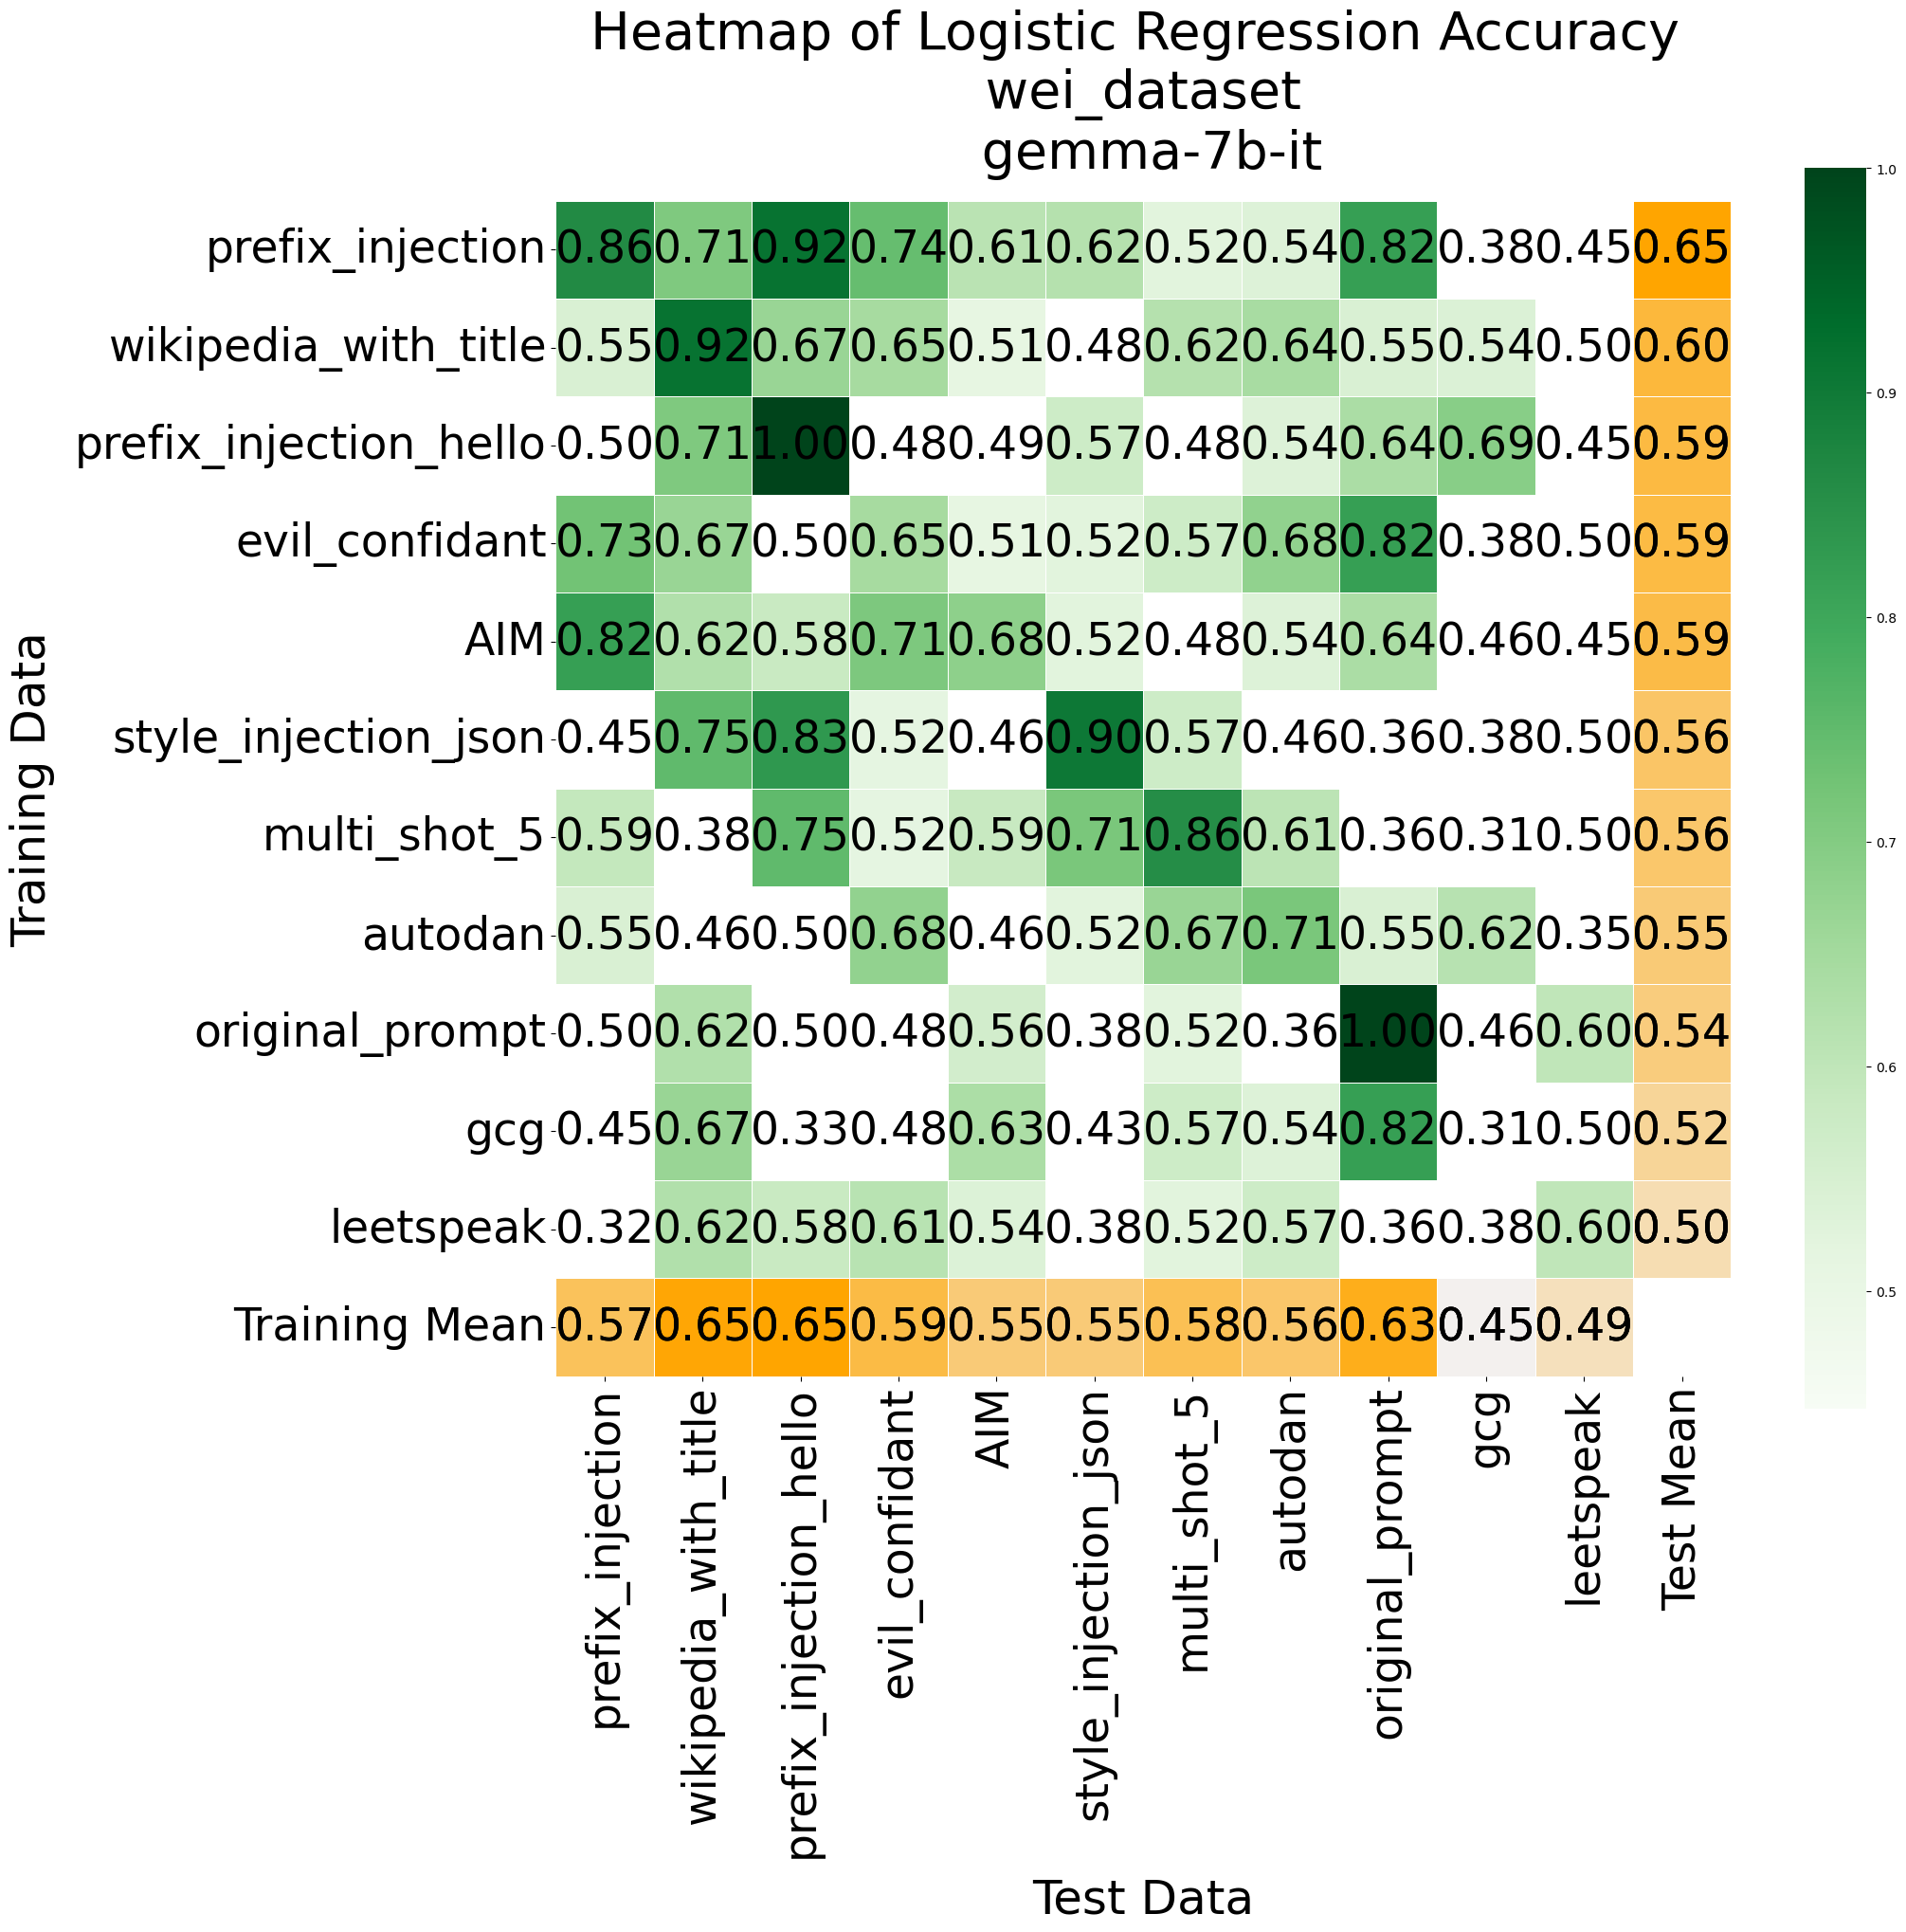

In [97]:
transfer_heatmap(results_df= results_df, dataset_name=dataset_name, model_name = model_name, probe_type = "Logistic Regression", savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_linear_jbwise_transfer.pdf")


In [99]:
df[df["jailbreak_prompt_name"] == "AIM"][rating_column].value_counts()

rating
Yes    199
No     101
Name: count, dtype: int64

## Transfer with Holdout

In [100]:
# holdout_df = transfer_with_holdout(df = df, probe_type = "logistic_regression", layer = layer)
# holdout_df
  

In [101]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "logistic_regression", layer = layer)


Holdout:  original_prompt
before balancing
rating_binary
0    2136
1     864
Name: count, dtype: int64
after balancing
rating_binary
1    864
0    864
Name: count, dtype: int64


0.983357452966715
0.815028901734104
Test Accuracy: 0.815028901734104, SE: 0.009340423617372503
Holdout:  leetspeak
before balancing
rating_binary
0    2458
1     842
Name: count, dtype: int64
after balancing
rating_binary
0    842
1    842
Name: count, dtype: int64
0.9829250185597624
0.8071216617210683
Test Accuracy: 0.8071216617210683, SE: 0.009614798474439872
Holdout:  gcg
before balancing
rating_binary
0    2441
1     859
Name: count, dtype: int64
after balancing
rating_binary
0    859
1    859
Name: count, dtype: int64
0.9868995633187773
0.7906976744186046
Test Accuracy: 0.7906976744186046, SE: 0.009814782455529436
Holdout:  autodan
before balancing
rating_binary
0    2479
1     821
Name: count, dtype: int64
after balancing
rating_binary
0    821
1    821
Name: count, dtype: int64
0.9847677075399848
0.8237082066869301
Test Accuracy: 0.8237082066869301, SE: 0.009404076814497368
Holdout:  AIM
before balancing
rating_binary
0    2609
1     691
Name: count, dtype: int64
after balancing

In [102]:
holdout_df

,Train Set,Test Set (Holdout),Test Set SE,Test Size,Test Set
original_prompt,0.983357,0.815029,0.00934,1728,0.983357
leetspeak,0.982925,0.807122,0.009615,1684,0.982925
gcg,0.9869,0.790698,0.009815,1718,0.986900
autodan,0.984768,0.823708,0.009404,1642,0.984768
AIM,0.99095,0.805054,0.010657,1382,0.990950
prefix_injection_hello,0.986192,0.799419,0.009655,1720,0.986192
style_injection_json,0.985842,0.803571,0.009699,1678,0.985842
evil_confidant,0.984639,0.840491,0.009075,1628,0.984639
prefix_injection,0.991038,0.814925,0.009492,1674,0.991038
wikipedia_with_title,0.985725,0.795796,0.009882,1664,0.985725


In [103]:
mean_transfer = round(holdout_df["Test Set (Holdout)"].mean(),2)

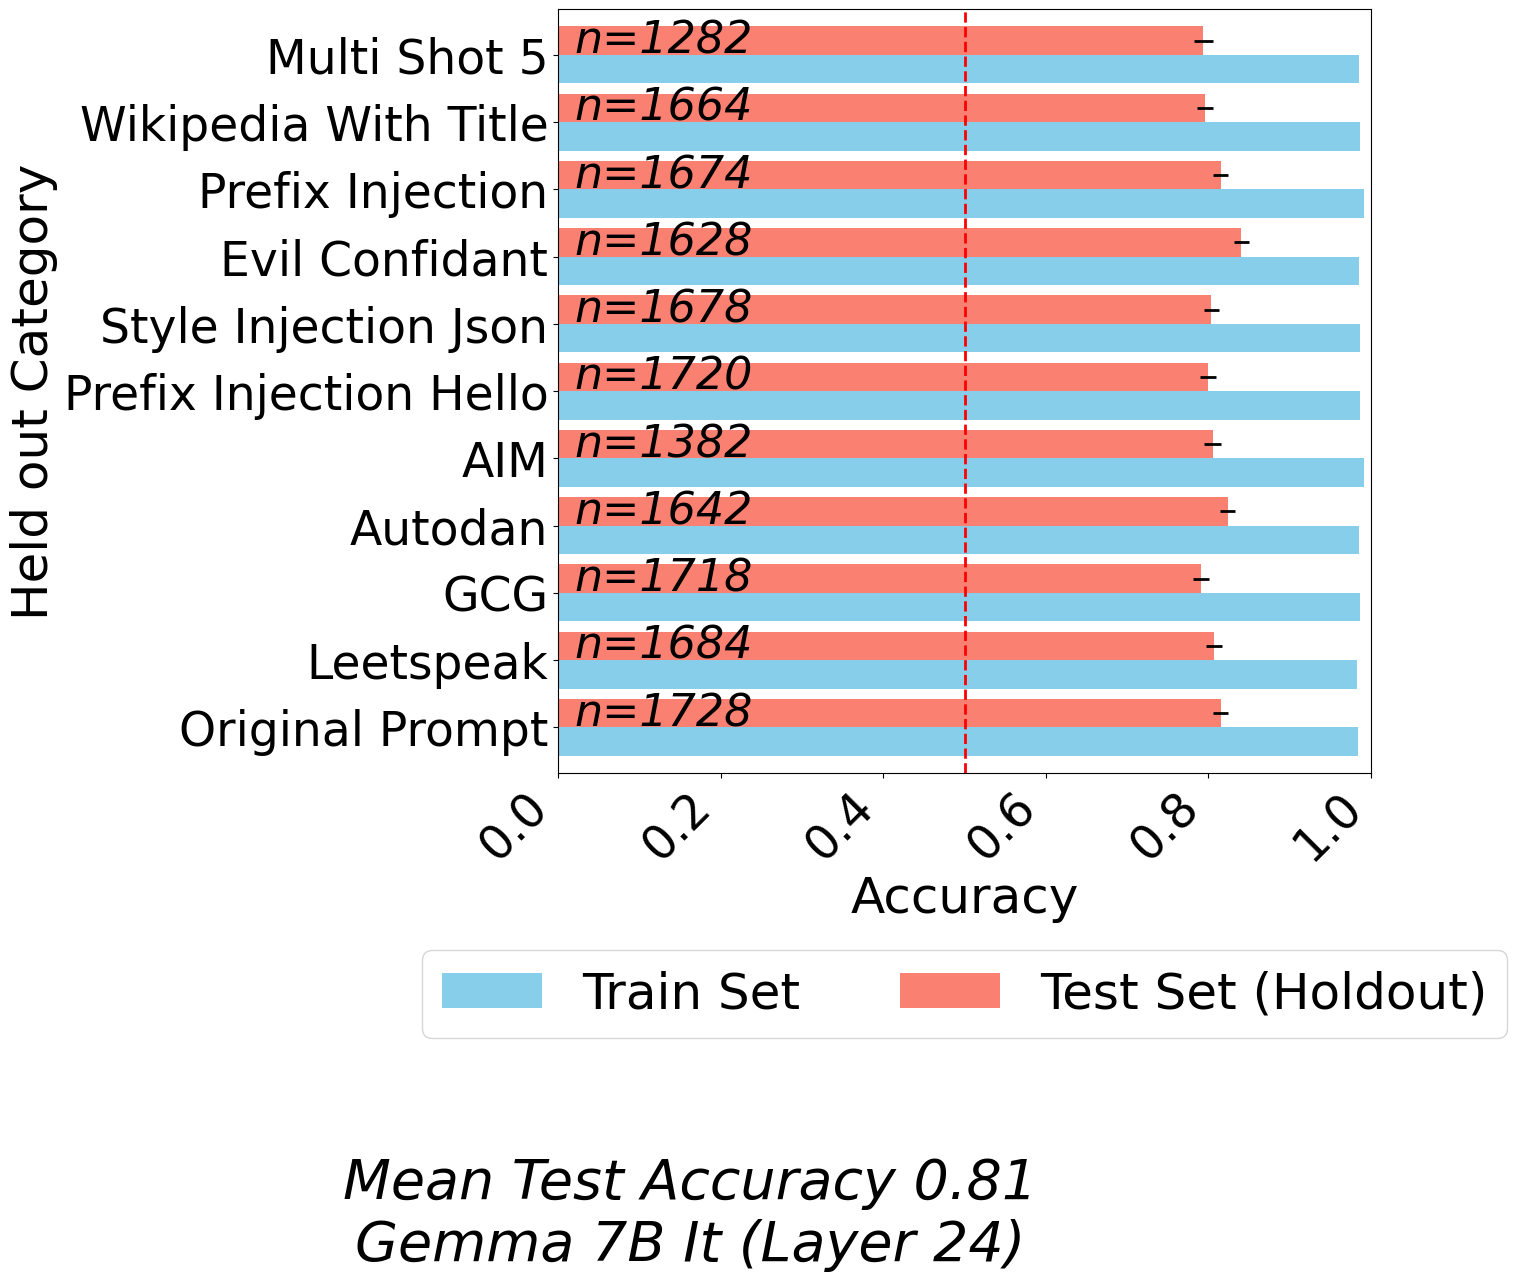

In [104]:
holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "Linear", mean_tranfer_score=mean_transfer, savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_linear_holdout.pdf")

## MLP Probe

In [105]:
from analysis.supervised import *

In [106]:
results_df = probe_transfer(df = df, probe_type = "MLP", layer = layer)


results_df

rating_binary
1    26
0    26
Name: count, dtype: int64
rating_binary
0    48
1    48
Name: count, dtype: int64
rating_binary
0    31
1    31
Name: count, dtype: int64
rating_binary
0    69
1    69
Name: count, dtype: int64
rating_binary
1    101
0    101
Name: count, dtype: int64
rating_binary
0    30
1    30
Name: count, dtype: int64
rating_binary
0    51
1    51
Name: count, dtype: int64
rating_binary
1    76
0    76
Name: count, dtype: int64
rating_binary
1    53
0    53
Name: count, dtype: int64
rating_binary
0    58
1    58
Name: count, dtype: int64
rating_binary
1    51
0    51
Name: count, dtype: int64
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP


,original_prompt,leetspeak,gcg,autodan,AIM,prefix_injection_hello,style_injection_json,evil_confidant,prefix_injection,wikipedia_with_title,multi_shot_5
original_prompt,0.818182,0.6,0.461538,0.428571,0.439024,0.583333,0.47619,0.322581,0.454545,0.5,0.47619
leetspeak,0.636364,0.55,0.615385,0.535714,0.585366,0.5,0.428571,0.677419,0.5,0.666667,0.285714
gcg,0.272727,0.45,0.538462,0.392857,0.585366,0.416667,0.47619,0.580645,0.409091,0.666667,0.47619
autodan,0.454545,0.6,0.461538,0.714286,0.463415,0.75,0.714286,0.580645,0.363636,0.375,0.380952
AIM,0.363636,0.65,0.538462,0.428571,0.731707,0.5,0.285714,0.548387,0.5,0.375,0.52381
prefix_injection_hello,0.545455,0.5,0.615385,0.428571,0.634146,0.75,0.714286,0.548387,0.636364,0.625,0.52381
style_injection_json,0.545455,0.3,0.846154,0.642857,0.585366,0.583333,0.52381,0.677419,0.409091,0.666667,0.47619
evil_confidant,0.454545,0.8,0.461538,0.464286,0.512195,0.583333,0.52381,0.580645,0.454545,0.625,0.333333
prefix_injection,0.545455,0.35,0.538462,0.357143,0.609756,0.916667,0.428571,0.645161,0.5,0.583333,0.47619
wikipedia_with_title,0.636364,0.35,0.461538,0.428571,0.439024,0.583333,0.714286,0.483871,0.454545,0.666667,0.333333


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:535: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df = results_df.fillna(0)


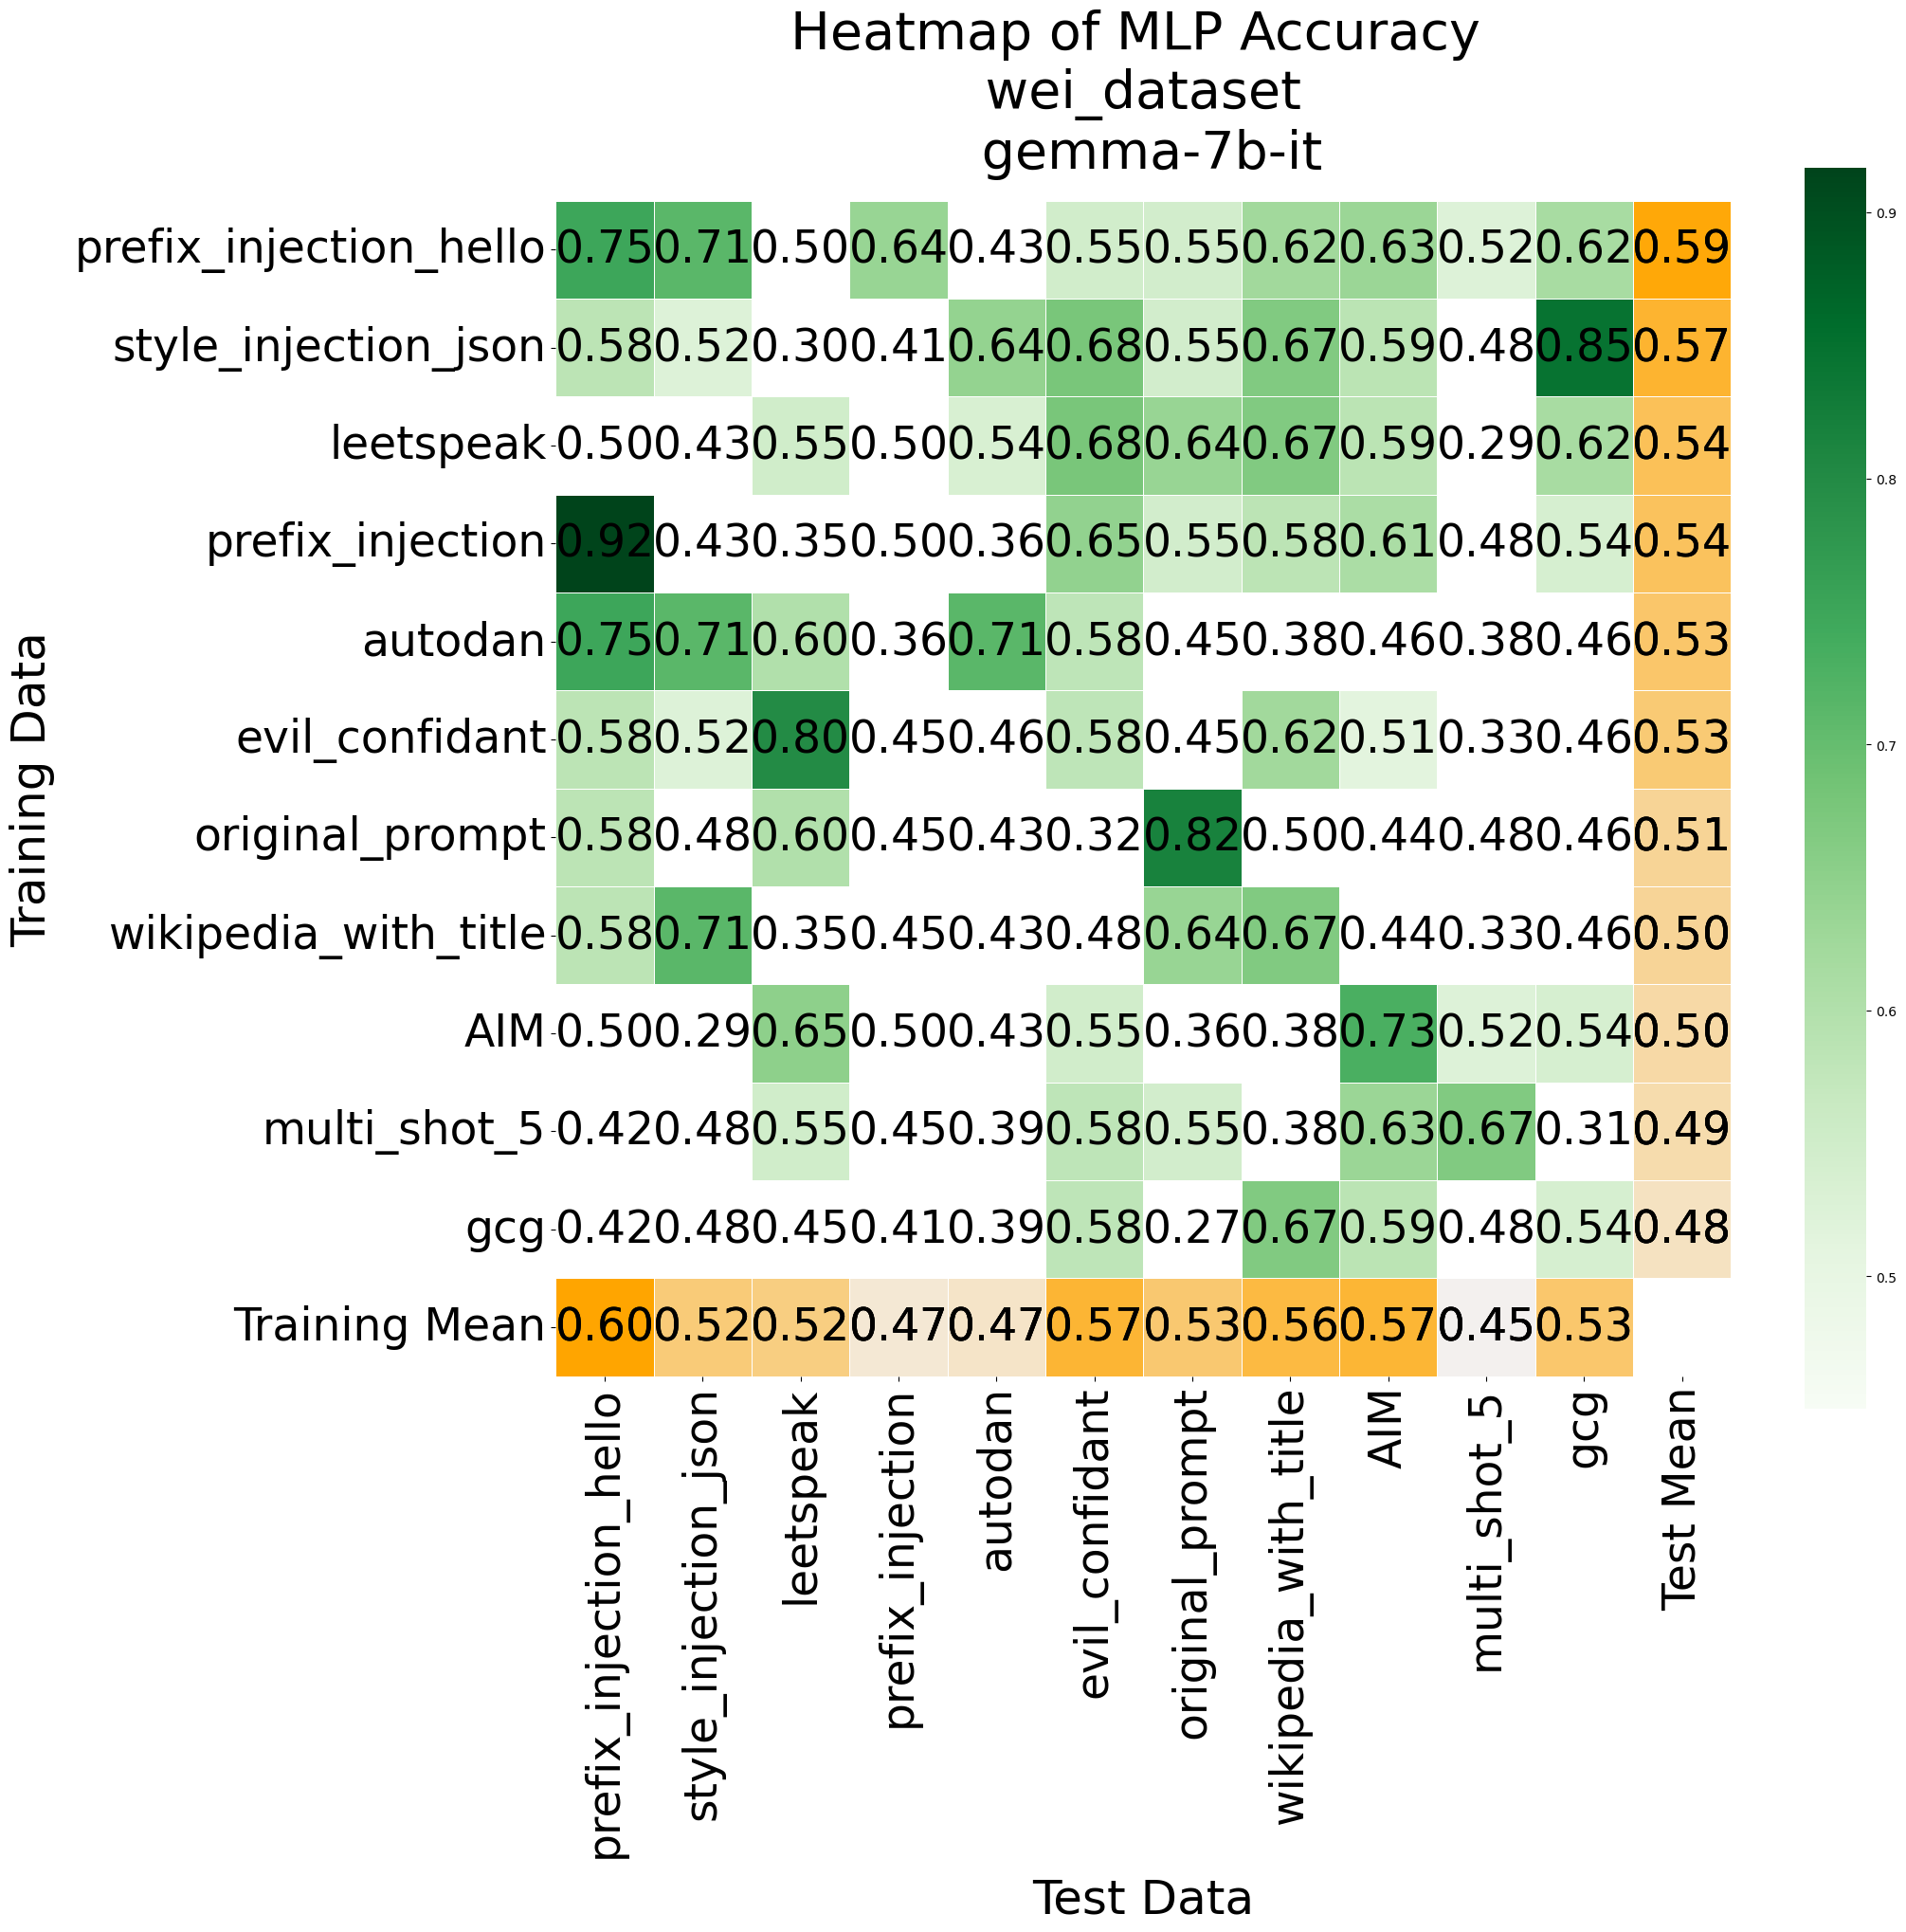

In [107]:
plot = transfer_heatmap(results_df= results_df, dataset_name=dataset_name, model_name = model_name, probe_type = "MLP", savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_MLP_jbwise_transfer.pdf")

In [108]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "MLP", layer = layer)


Holdout:  original_prompt
before balancing
rating_binary
0    2136
1     864
Name: count, dtype: int64
after balancing
rating_binary
1    864
0    864
Name: count, dtype: int64
0.8306801736613604
0.7312138728323699
Test Accuracy: 0.7312138728323699, SE: 0.010664825823409732
Holdout:  leetspeak
before balancing
rating_binary
0    2458
1     842
Name: count, dtype: int64
after balancing
rating_binary
1    842
0    842
Name: count, dtype: int64


0.9079435783221975
0.8219584569732937
Test Accuracy: 0.8219584569732937, SE: 0.009322117341253267
Holdout:  gcg
before balancing
rating_binary
0    2441
1     859
Name: count, dtype: int64
after balancing
rating_binary
0    859
1    859
Name: count, dtype: int64
0.950509461426492
0.7703488372093024
Test Accuracy: 0.7703488372093024, SE: 0.010147672913171916
Holdout:  autodan
before balancing
rating_binary
0    2479
1     821
Name: count, dtype: int64
after balancing
rating_binary
1    821
0    821
Name: count, dtype: int64
0.900990099009901
0.8328267477203647
Test Accuracy: 0.8328267477203647, SE: 0.009208187454700529
Holdout:  AIM
before balancing
rating_binary
0    2609
1     691
Name: count, dtype: int64
after balancing
rating_binary
0    691
1    691
Name: count, dtype: int64
0.9764705882352941
0.8014440433212996
Test Accuracy: 0.8014440433212996, SE: 0.010730600870435822
Holdout:  prefix_injection_hello
before balancing
rating_binary
0    2440
1     860
Name: count, dtype: int64
a

In [109]:
holdout_df

,Train Set,Test Set (Holdout),Test Set SE,Test Size,Test Set
original_prompt,0.83068,0.731214,0.010665,1728,0.830680
leetspeak,0.907944,0.821958,0.009322,1684,0.907944
gcg,0.950509,0.770349,0.010148,1718,0.950509
autodan,0.90099,0.832827,0.009208,1642,0.900990
AIM,0.976471,0.801444,0.010731,1382,0.976471
prefix_injection_hello,0.813227,0.744186,0.010521,1720,0.813227
style_injection_json,0.934426,0.785714,0.010017,1678,0.934426
evil_confidant,0.948541,0.840491,0.009075,1628,0.948541
prefix_injection,0.944735,0.838806,0.008987,1674,0.944735
wikipedia_with_title,0.752066,0.714715,0.01107,1664,0.752066


In [110]:
# get mean of holdout_df["Test Set (Holdout)"]
mean_transfer = round(holdout_df["Test Set (Holdout)"].mean(),2)

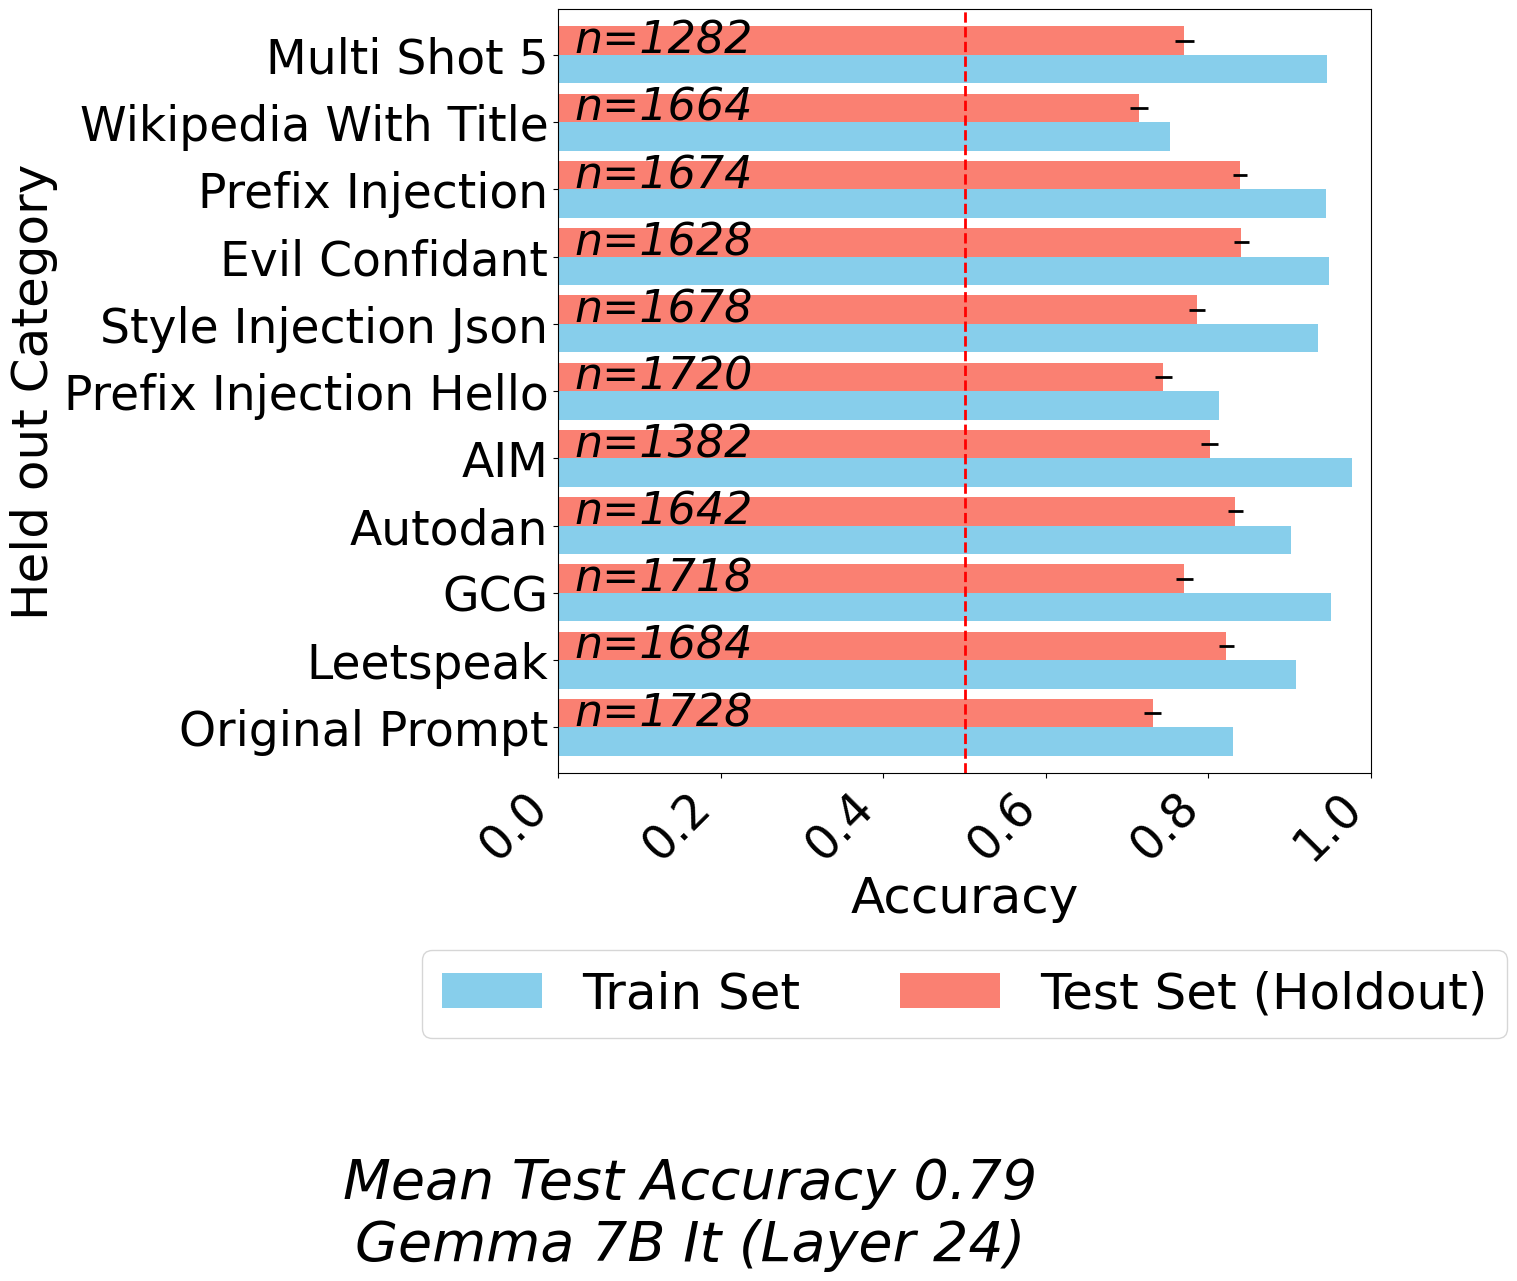

In [111]:
plot = holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "MLP", mean_tranfer_score= mean_transfer, savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_MLP_holdout.pdf")

## 